In [24]:
import pandas as pd
import numpy as np
import re
import scipy as sp

# nltk.download()
import nltk
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer
from nltk.stem import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
import emoji

import gensim

from gensim.parsing.preprocessing import strip_punctuation
from gensim.parsing.preprocessing import strip_short
from gensim.parsing.preprocessing import strip_multiple_whitespaces
from gensim.parsing.preprocessing import stem_text
from gensim.models import KeyedVectors

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, r2_score, mean_squared_error, median_absolute_error, mean_absolute_error 

import lightgbm as lgb

pd.set_option('display.float_format', '{:,.2f}'.format)
import warnings
warnings.filterwarnings("ignore")
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Грузим данные

In [45]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
sample_sub = pd.read_csv("sample_submission(1).csv")

# Распределение оценок

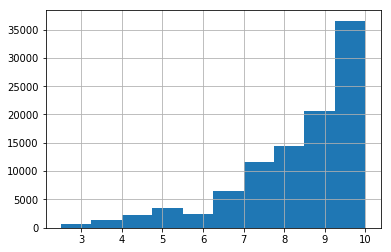

In [46]:
train['score'].hist()

In [47]:
stopwords = nltk.corpus.stopwords.words('english')
lan = LancasterStemmer()
porter = PorterStemmer()
snow = SnowballStemmer('english')
wordnet_lemmatizer = WordNetLemmatizer()

def text_process(text):
    
    text = re.sub(r"won\'t", "will not", text)
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    
    text = emoji.demojize(text)
    text = text.lower()
    text = re.sub(r"<img.*?>", '', text) # images
    text = re.sub('http://\S+|https://\S+', '', text) # links
    text = ''.join([i for i in text if not i.isdigit()]) # digits
    text = re.sub(r'[0-9]+(?:\.[0-9]+){3}', '', text) # ip
    text = re.sub("^\d+\s|\s\d+\s|\s\d+$", '', text)
    text = re.sub(r"[^\w\d'\s]+",'', text) # punct
    
    text = re.sub(r"_", ' ', text)
    text = strip_multiple_whitespaces(text)
    text = list(text.split())
    texts = [word for word in text if word not in stopwords]
    
    review = []
    for text in texts:
#         text = porter.stem(text)
        text = wordnet_lemmatizer.lemmatize(text, pos="v")
        review.append(text)
    return ' '.join(review)

In [48]:
train['text'] = train['negative'] + ' ' + train['positive']

train['total_length'] = train['text'].apply(len)
train['capitals'] = train['text'].apply(lambda comment: sum(1 for c in comment if c.isupper()))
train['caps_vs_length'] = train.apply(lambda row: float(row['capitals'])/float(row['total_length']), axis=1)
train['num_exclamation_marks'] = train['text'].apply(lambda comment: comment.count('!'))
train['num_punctuation'] = train['text'].apply(lambda comment: sum(comment.count(w) for w in '.,;:'))
train['num_unique_words'] = train['text'].apply(lambda comment: len(set(w for w in comment.split())))

test['text'] = test['negative'] + ' ' + test['positive']
test['total_length'] = test['text'].apply(len)
test['capitals'] = test['text'].apply(lambda comment: sum(1 for c in comment if c.isupper()))
test['caps_vs_length'] = test.apply(lambda row: float(row['capitals'])/float(row['total_length']), axis=1)
test['num_exclamation_marks'] = test['text'].apply(lambda comment: comment.count('!'))
test['num_punctuation'] = test['text'].apply(lambda comment: sum(comment.count(w) for w in '.,;:'))
test['num_unique_words'] = test['text'].apply(lambda comment: len(set(w for w in comment.split())))

new_features = ['capitals', 'caps_vs_length', 'num_exclamation_marks', 'num_punctuation', 'num_unique_words']

scaler = StandardScaler()
scaler.fit(np.vstack((train[new_features], test[new_features])))
train[new_features] = scaler.transform(train[new_features])
test[new_features] = scaler.transform(test[new_features])

In [49]:
X = train['text'].map(text_process)
XX = test['text'].apply(text_process)

vectorizer = TfidfVectorizer(ngram_range=(1, 2), min_df=3, max_df=0.9, strip_accents='unicode', max_features=2500)
X_tfidf = vectorizer.fit_transform(X)
XX_tfidf = vectorizer.transform(XX)

train_data = sp.sparse.hstack((X_tfidf, train[new_features]))
test_data = sp.sparse.hstack((XX_tfidf, test[new_features]))

target = train['score']

In [50]:
X_train, X_test, y_train, y_test = train_test_split(train_data, target, test_size=0.2)
train_data = lgb.Dataset(X_train, label=(y_train.values),
                                 free_raw_data=False)

# train test split

In [51]:
params = {
            'boosting_type': 'gbdt',
            'objective': 'regression',
            'metric': {'mae'},
            'num_leaves': 100,
            'learning_rate': 0.01,
            'num_iterations': 1000,
            'feature_fraction': 0.8,
            'bagging_fraction': 0.8,
            'bagging_freq': 5,
            'verbose': 0,
            'n_jobs': 16,
            'max_depth': 100,
            'max_bin': 1000
        }

regr_ncl = lgb.train(
    params,
    train_data,
    num_boost_round=1200,
    verbose_eval=10
)

In [52]:
y_pred = regr_ncl.predict(X_test, num_iteration=regr_ncl.best_iteration)

print('mse '+str(mean_squared_error(y_test, y_pred)))
print('median_ae '+str(median_absolute_error(y_test, y_pred)))
print('mae '+str(mean_absolute_error(y_test, y_pred)))
print('real_mean '+str(y_test.mean()))
print('model_mean '+str(y_pred.mean()))
print('real_median '+str(y_test.median()))
print('model_median '+str(np.median(y_pred)))

mse 1.3090601673455735
median_ae 0.6543552666735866
mae 0.8536787686289805
real_mean 8.39695
model_mean 8.3906521543584
real_median 8.8
model_median 8.655832775220667


# fasttext

In [25]:
model2vec = KeyedVectors.load_word2vec_format('wiki-news-300d-1M.vec')

In [26]:
def word_to_vec(text):
    review = np.mean([model2vec['good'], model2vec['bad']], axis=0) # если модель не нашла ни одного слова в fasttext
    embeddings = [model2vec[word.lower()] for word in text if word.lower() in model2vec.vocab]
    if len(embeddings) > 0:
        review = np.mean(embeddings, axis=0)
    return review

In [41]:
X_fasttext = X.apply(word_to_vec)
XX_fasttext = XX.apply(word_to_vec)

X_fasttext = pd.DataFrame(X_fasttext.values.tolist())
XX_fasttext = pd.DataFrame(XX_fasttext.values.tolist())
X_fasttext[new_features] = train[new_features]
XX_fasttext[new_features] = test[new_features]

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X_fasttext, target, test_size=0.2)
train_data = lgb.Dataset(X_train, label=(y_train.values), free_raw_data=False)

In [43]:
params = {
            'boosting_type': 'gbdt',
            'objective': 'regression',
            'metric': {'mae'},
            'num_leaves': 100,
            'learning_rate': 0.01,
            'num_iterations': 1000,
            'feature_fraction': 0.8,
            'bagging_fraction': 0.8,
            'bagging_freq': 5,
            'verbose': 0,
            'n_jobs': 16,
            'max_depth': 100,
            'max_bin': 1000
        }

regr_ncl = lgb.train(
    params,
    train_data,
    num_boost_round=1200,
    verbose_eval=10
)

In [44]:
y_pred = regr_ncl.predict(X_test, num_iteration=regr_ncl.best_iteration)

print('mse '+str(mean_squared_error(y_test, y_pred)))
print('median_ae '+str(median_absolute_error(y_test, y_pred)))
print('mae '+str(mean_absolute_error(y_test, y_pred)))
print('real_mean '+str(y_test.mean()))
print('model_mean '+str(y_pred.mean()))
print('real_median '+str(y_test.median()))
print('model_median '+str(np.median(y_pred)))

mse 2.088969465843118
median_ae 0.8731071031898843
mae 1.1018318627426924
real_mean 8.384245
model_mean 8.392546520896234
real_median 8.8
model_median 8.43878808806707


# Предсказания

In [53]:
sample_sub['score'] = regr_ncl.predict(test_data)

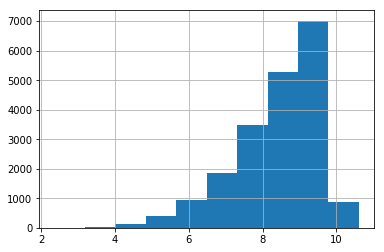

In [54]:
sample_sub['score'].hist()

In [55]:
sample_sub.to_csv('ans.csv', index=False)